In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
%%capture

from extractor import get_dataset

path = 'dataset/games.pgn'
num_games = 30000
device ='cuda'

X, Y = get_dataset(path, num_games=num_games, device=device)

In [3]:
X.shape, Y.shape

(torch.Size([2180, 773]), torch.Size([2180]))

In [4]:
def view_matrix(x):
    img = torch.zeros((784))
    img[:x.shape[0]] = x.to(device).detach().clone()
    plt.imshow(img.view(28,28),cmap='gray')

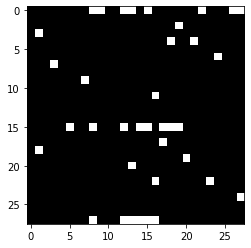

In [5]:
view_matrix(X[69])

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(773,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100)
        )

        self.decoder = nn.Sequential(
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,773),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


In [7]:
dataset = TensorDataset(X,Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)

In [9]:
track = X[0].view(1,-1).detach()
track.shape

torch.Size([1, 773])

In [10]:
X.shape[0]

2180

In [11]:
epochs = 50
outputs = []
losses = []

print_interval = X.shape[0]//(64*10)

for epoch in range(epochs):
    running_loss = 0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (x, _) in enumerate(loader):
        out = model(x)
        loss = criterion(out,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % print_interval == print_interval - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (print_interval):.3f}')
            running_loss = 0.0
    losses.append(running_loss)
    outputs.append(model(track))
print('finished_training')


Epoch 1
-------------------------------
[1,     3] loss: 0.250
[1,     6] loss: 0.250
[1,     9] loss: 0.250
[1,    12] loss: 0.250
[1,    15] loss: 0.250
[1,    18] loss: 0.250
[1,    21] loss: 0.250
[1,    24] loss: 0.250
[1,    27] loss: 0.250
[1,    30] loss: 0.250
[1,    33] loss: 0.250
Epoch 2
-------------------------------
[2,     3] loss: 0.250
[2,     6] loss: 0.250
[2,     9] loss: 0.250
[2,    12] loss: 0.249
[2,    15] loss: 0.249
[2,    18] loss: 0.249
[2,    21] loss: 0.249
[2,    24] loss: 0.249
[2,    27] loss: 0.249
[2,    30] loss: 0.249
[2,    33] loss: 0.249
Epoch 3
-------------------------------
[3,     3] loss: 0.249
[3,     6] loss: 0.249
[3,     9] loss: 0.249
[3,    12] loss: 0.249
[3,    15] loss: 0.249
[3,    18] loss: 0.249
[3,    21] loss: 0.249
[3,    24] loss: 0.249
[3,    27] loss: 0.249
[3,    30] loss: 0.249
[3,    33] loss: 0.249
Epoch 4
-------------------------------
[4,     3] loss: 0.249
[4,     6] loss: 0.249
[4,     9] loss: 0.249
[4,    12] l

In [12]:
outputs[0].shape, track.shape

(torch.Size([1, 773]), torch.Size([1, 773]))

In [14]:
track[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

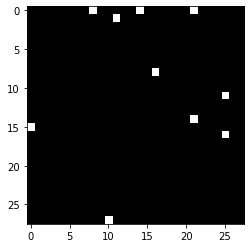

In [13]:
view_matrix(track[0])

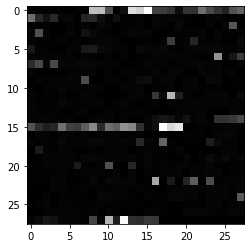

In [14]:
view_matrix(outputs[1][0])

In [15]:
class DeepChess(nn.Module):
    def __init__(self):
        super().__init__()
        self.e = model.encoder
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,2)
    def forward(self, x1, x2):
        x1 = self.e(x1)
        x2 = self.e(x2)
        x = torch.cat((x1,x2),-1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = DeepChess().to(device) 

In [16]:
#20% val 80 train

split = int(X.shape[0]*0.8)

dataset_train = TensorDataset(X[:split,:],Y[:split])
dataset_test = TensorDataset(X[split:,:],Y[split:])

loader1 = DataLoader(dataset_train,batch_size=64,shuffle=True)
loader2 = DataLoader(dataset_train,batch_size=64,shuffle=True)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.1)

In [20]:
epochs = 150 #do 200 for tetsing 
losses = []

print_interval = X.shape[0]//(64*10)

for epoch in range(epochs):
    running_loss = 0
    for batch, (data1, data2) in enumerate(zip(loader1,loader2)):
        x1, y1 = data1
        x2, y2 = data2
        pred = net(x1,x2)
        
        target = torch.stack((y1,y2),dim=1)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch % print_interval == print_interval - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (print_interval):.3f}')
            running_loss = 0.0
    
    losses.append(running_loss)

print('finished_training')


[1,   296] loss: 0.776
[1,   592] loss: 0.780
[1,   888] loss: 0.773
[1,  1184] loss: 0.782
[1,  1480] loss: 0.777
[1,  1776] loss: 0.781
[1,  2072] loss: 0.782
[1,  2368] loss: 0.774
[2,   296] loss: 0.776
[2,   592] loss: 0.779
[2,   888] loss: 0.777
[2,  1184] loss: 0.780
[2,  1480] loss: 0.773
[2,  1776] loss: 0.776
[2,  2072] loss: 0.768
[2,  2368] loss: 0.761
[3,   296] loss: 0.750
[3,   592] loss: 0.750
[3,   888] loss: 0.740
[3,  1184] loss: 0.730
[3,  1480] loss: 0.736
[3,  1776] loss: 0.727
[3,  2072] loss: 0.725
[3,  2368] loss: 0.728
[4,   296] loss: 0.734
[4,   592] loss: 0.718
[4,   888] loss: 0.716
[4,  1184] loss: 0.720
[4,  1480] loss: 0.715
[4,  1776] loss: 0.710
[4,  2072] loss: 0.723
[4,  2368] loss: 0.712
[5,   296] loss: 0.707
[5,   592] loss: 0.707
[5,   888] loss: 0.703
[5,  1184] loss: 0.708
[5,  1480] loss: 0.696
[5,  1776] loss: 0.694
[5,  2072] loss: 0.701
[5,  2368] loss: 0.699
[6,   296] loss: 0.692
[6,   592] loss: 0.691
[6,   888] loss: 0.683
[6,  1184] 

In [ ]:
import os
duration = 1  # seconds
freq = 120  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

In [ ]:
#test 
train_loader1 = DataLoader(dataset_train,shuffle=True,batch_size=1)
train_loader2 = DataLoader(dataset_train,shuffle=True,batch_size=1)

In [ ]:
acc = 0
count = 0
with torch.no_grad():
    for data1, data2 in zip(train_loader1, train_loader2):
        x1, y1 = data1
        x2, y2 = data2
        #pred = nn.functional.softmax(net(x1,x2),dim=-1)
        pred = net(x1,x2)
        y = torch.stack((y1,y2),dim=1)
        count += torch.sum(torch.argmax(pred) == torch.argmax(y))

In [ ]:
count/len(dataset_train) * 100

NameError: name 'count' is not defined

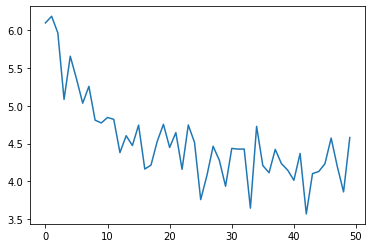

In [ ]:
plt.plot(losses)